In [1]:
# Import libraries 
from tqdm import tqdm

import numpy as np
from sklearn.datasets import make_blobs, make_circles
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt

#### I. Generate training data.

Understanding the data input:
- `X` denotes the training dataset, where each row represents number of examples (`m`), whilst each column represents features (`n_x`). `X` has a shape of `(m, n_x)`. For instance, `X` has 1000 examples with 2 features each.
- `Y` represents the output with a shape `(m, 1)`.

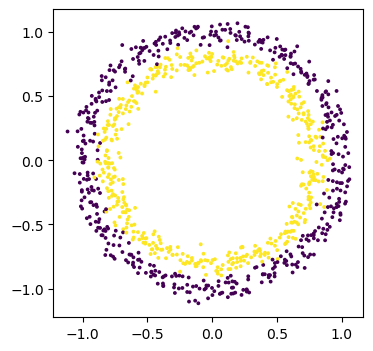

In [27]:
# Generate more complex data
X, Y = make_circles(
    n_samples=1000,
    noise=0.05,
    random_state=42,
) 
# Add dimension to the Y
Y = Y.reshape(-1, 1)

# Convert generated data into tensors
X_tensor = torch.from_numpy(X).float()
Y_tensor = torch.from_numpy(Y).float()

# Plot the data
plt.figure(figsize=(4, 4))
plt.scatter(X[:,0], X[:,1], c=Y, s=3)

#### II. Data splitting and DataLoader defintions

In [5]:
def split_train_val_and_test_set(X, Y, train_ratio, validation_ratio, test_ratio):
    """ Split datasets into training, validation, and test sets."""
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=train_ratio)
    X_val, X_test, Y_val, Y_test = train_test_split(X_test, Y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 
    return X_train, Y_train, X_val, Y_val, X_test, Y_test

In [8]:
class Dataset(torch.utils.data.Dataset):
  """ Characterizes a dataset for PyTorch."""
    
  def __init__(self, X, Y):
      """ Initialize the datasets."""
      self.X = X
      self.Y = Y

  def __len__(self):
      """ Return the number of training examples."""
      return self.X.shape[0]

  def __getitem__(self, index):
      """ Generate one sample of the training data."""
      x = self.X[index, :]
      y = self.Y[index, :]
      return x, y

#### III. Model definitions

In [154]:
# Define a simple two layer network
class LLayerNN(nn.Module):
    """ 
    Implementation of a general L-layer fully connected neural network.
    """
    
    def __init__(self, network_params):
        super().__init__()

        self.activations = nn.ModuleDict([
            ['sigmoid', nn.Sigmoid()],
            ['tanh', nn.Tanh()],
            ['relu', nn.ReLU()],
        ])

        blocks = []
        for L_param in network_params[:-1]:
            blocks.append(self._linear_block(
                in_features=L_param[0], 
                out_features=L_param[1], 
                activation=L_param[2],
                dropout_prob=L_param[3],
            ))
        self.block = nn.Sequential(*blocks)
        
        self.linear = nn.Linear(
            in_features=network_params[-1][0], 
            out_features=network_params[-1][1]
        )
        self.sigmoid = nn.Sigmoid()

    def _linear_block(self, in_features, out_features, activation="relu", dropout_prob=0.0):
        
        return nn.Sequential(
            nn.Linear(in_features=in_features, out_features=out_features),
            nn.Dropout(p=dropout_prob),
            self.activations[activation],
        )
        
    def forward(self, x):
        x = self.block(x)
        x = self.linear(x)
        output = self.sigmoid(x)
        return output

In [136]:
def train_loop(dataloader, model, loss_fn, optimizer):
    """ Perform a training loop."""
    running_loss = 0
    
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    
    for batch, (X, y) in enumerate(dataloader):
        
        # Send the batch samples to a device
        X, y = X.to(device), y.to(device)
        
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        running_loss += loss.item()
        
        # Backpropagation
        loss.backward()
        # Update model weights
        optimizer.step()
        # Re-set gradients to zero for next batch
        optimizer.zero_grad()

    avg_training_loss = running_loss / len(dataloader)
    
    return avg_training_loss

In [137]:
def validation_loop(dataloader, model, loss_fn):
    """ Perform a validation loop."""
    running_loss = 0
    
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:

            # Send the batch samples to a device
            X, y = X.to(device), y.to(device)
            
            # Compute prediction and loss
            pred = model(X)
            loss = loss_fn(pred, y)
            running_loss += loss.item()

    avg_validation_loss = running_loss / len(dataloader)

    return avg_validation_loss

In [138]:
def predict(model, X):
    """ Make model predictions."""
    with torch.no_grad():
        # Make a prediction
        y_pred = model(X)
        y_pred[y_pred >= 0.5] = 1
        y_pred[y_pred < 0.5] = 0
    return y_pred

def accuracy_fn(y_true, y_pred):
    """ Compute accuraccy."""
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [139]:
def train_model(training_generator, validation_generator, model, loss_fn, optimizer, epochs):
    
    # Collect results
    training_loss = []
    validation_loss = []
    
    for epoch in tqdm(range(epochs)):  # loop over the dataset multiple times

        # Perform a training step
        running_training_loss = train_loop(
            dataloader=training_generator, 
            model=model,
            loss_fn=loss_fn,
            optimizer=optimizer
        )
        training_loss.append(running_training_loss)

        # Perform a validation step
        running_validation_loss = validation_loop(
            dataloader=validation_generator,
            model=model,
            loss_fn=loss_fn
        )
        validation_loss.append(running_validation_loss)

    return training_loss, validation_loss

In [140]:
def plot_loss(training_loss, validation_loss, model_id):
    """ Plot training and validation losses."""
    fig = plt.figure(figsize=[5, 3])
    ax = fig.add_subplot(111)
    ax.plot(training_loss, label="Training loss")
    ax.plot(validation_loss, label="Validation loss")
    ax.set_title("Model: {}".format(model_id))
    ax.legend()

#### IV. Train a model

In [141]:
# Define Global variables

# Define training tools
loss_functions = {
    "binary_cross_entropy": nn.BCELoss,
}
optimizers = {
    "SGD": optim.SGD,
}
# Search for a device
device = (
    "cuda:0"
    if torch.cuda.is_available()
    else "cpu"
)

In [142]:
# Define parameters configuration
# https://github.com/victoresque/pytorch-template/blob/master/README.md
params = {
    "data_splitting" : {
        "train_ratio": 0.8,
        "validation_ratio": 0.1,
        "test_ratio": 0.1,
    },
    
    "dataloader": {
        "batch_size": 4,
        "shuffle": True,
        "num_workers" : 0
    },
    
    "loss": {
        "type": "binary_cross_entropy",
        "params" : {
            "reduction": "mean"
        }
    },

    "optimizer": {
        "type": "SGD",
        "params": {
            "lr": 0.001,
            "momentum": 0,
            "weight_decay": 0.001,
        }
    },

    "training": {
        "epochs" : 2000
    },
}  

In [2]:
# Split the data into training, validation, and test sets
X_train, Y_train, X_val, Y_val, X_test, Y_test = split_train_val_and_test_set(
    X=X_tensor, 
    Y=Y_tensor, 
    **params["data_splitting"]
)

In [ ]:
# Define datasets generators
# Training
training_dataset = Dataset(X=X_train, Y=Y_train)
training_generator = DataLoader(training_dataset, **params["dataloader"])
# Validation
validation_dataset = Dataset(X=X_val, Y=Y_val)
validation_generator = DataLoader(validation_dataset, **params["dataloader"])

In [164]:
# Instantiate a model
network_params = [
    # [in_f, out_f, activation, dropout_prob]
    [2, 10, "tanh", 0.0],
    [10, 10, "tanh", 0.0],
    [10, 1, "none", "none"],
]
model = LLayerNN(network_params=network_params)
# Transfer the model to device
model.to(device)

# Number of epochs
epochs = params["training"]["epochs"]
# Define a binary cross entropy loss
loss_fn = loss_functions[params["loss"]["type"]](**params["loss"]["params"])
# Define a stochastic gradient descent as an optimizer
optimizer = optimizers[params["optimizer"]["type"]](model.parameters(), **params["optimizer"]["params"])

In [165]:
# Train and evaluate the model
training_loss, validation_loss = train_model(
    training_generator=training_generator, 
    validation_generator=validation_generator, 
    model=model, 
    loss_fn=loss_fn, 
    optimizer=optimizer, 
    epochs=epochs
)

100%|███████████████████████████████████████████████████████████████████████████████| 2000/2000 [07:34<00:00,  4.40it/s]


Model accuracy: 98.0


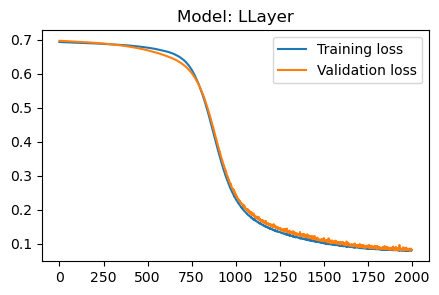

In [166]:
# Plot training and validation losses and calculate model accuracy
plot_loss(training_loss, validation_loss, "LLayer")
y_pred = predict(X=X_test.to(device), model=model)
accuracy = accuracy_fn(y_true=Y_test, y_pred=y_pred.cpu())
print("Model accuracy: {}".format(accuracy))

In [167]:
def plot_mislabeled_values(X_train, Y_train, X_test, Y_test, model, device):
    
    # Make a prediction
    Y_prediction_train = predict(X=X_train.to(device), model=model).to("cpu")
    Y_prediction_test = predict(X=X_test.to(device), model=model).to("cpu")
    
    # Mask values that have been mislabeled
    mask_train = np.abs(Y_prediction_train - Y_train) == 1
    mask_test = np.abs(Y_prediction_test - Y_test) == 1
    X_train_masked = X_train[mask_train.T[0]]
    X_test_masked = X_test[mask_test.T[0]]

    fig = plt.figure(figsize=[4, 4])
    ax = fig.add_subplot(111)
    ax.scatter(X_train[:, 0], X_train[:, 1], c=Y_train, cmap="coolwarm", s=5)
    ax.scatter(X_train[:, 0], X_train[:, 1], c=Y_train, cmap="coolwarm", s=5)
    ax.scatter(X_train_masked[:, 0], X_train_masked[:, 1], color="salmon", edgecolor="k", s=15)
    ax.scatter(X_test_masked[:, 0], X_test_masked[:, 1], color="aliceblue", edgecolor="k", s=15)

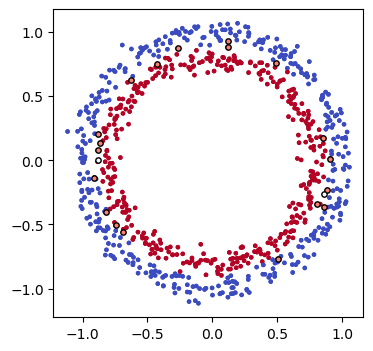

In [168]:
plot_mislabeled_values(X_train=X_train, Y_train=Y_train, X_test=X_test, Y_test=Y_test, model=model, device=device)

In [169]:
def plot_decision_boundary(X, Y, model, device):
    
    # Define the axis boundaries of the plot and create a meshgrid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                       np.linspace(y_min, y_max, 100))
    
    # Create X values (we're going to predict on all of these)
    x_in = np.c_[xx.ravel(), yy.ravel()] 
    
    # Make predictions using the trained model
    y_pred = predict(X=torch.tensor(x_in).float().to(device), model=model)
    y_pred = torch.round(y_pred).reshape(xx.shape)
    
    # Plot decision boundary
    fig = plt.figure(figsize=[4, 4])
    ax = fig.add_subplot(111)
    ax.contourf(xx, yy, y_pred.cpu().numpy(), cmap=plt.cm.RdYlBu, alpha=0.7)
    ax.scatter(X[:, 0], X[:, 1], c=Y, s=5, cmap=plt.cm.RdYlBu)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())

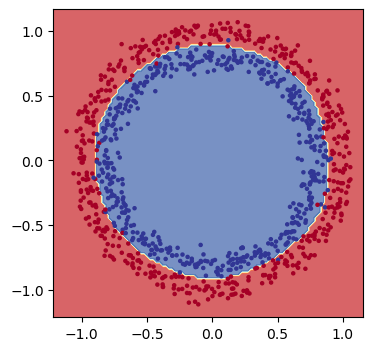

In [170]:
plot_decision_boundary(X=X, Y=Y, model=model, device=device)